In [2]:
#Import the necessary libraries
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import CSVLogger
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/Users/andrewhollar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [175]:
#Load the data into dataframe
#REQUIREMENTS:
    #1. Download the dataset from: https://github.com/karoldvl/ESC-50
    #2. have the dataset in the same directory as this python notebook
    
data = pd.read_csv('ESC-50-master/meta/esc50.csv')

In [176]:
#Should be (2000,7)
data.shape

(2000, 7)

In [152]:
D = []
i = 0
#load the spectrograms and their labels into D
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [140]:
i = 0
#Loop to take the initial sound files and slow them down by a factor of .81x
#NOTE: This requires that there is a directory named TimeStretchWavFiles/slow/ in the same folder
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=4.97)
    y_changed = librosa.effects.time_stretch(y, rate=0.81)
    librosa.output.write_wav('TimeStretchWavFiles/slow/' + testFile, y_changed, sr)
    i = i + 1

In [160]:
i = 0
#Loop to take the initial sound files and speed them up by a factor of 1.07x
#NOTE: This requires that there is a directory named TimeStretchWavFiles/fast/ in the same folder
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=4.97)
    y_changed = librosa.effects.time_stretch(y, rate=1.07)
    librosa.output.write_wav('TimeStretchWavFiles/fast/' + testFile, y_changed, sr)
    i = i + 1

In [93]:
i = 0
n_steps = 2 #-1, -2, 2, 1

#Loop to take the initial sound files and create new sound files that
#have had their pitch changed by 2 half steps
#NOTE: This requires that there is a directory named PitchChangeWavFiles/Change1/ in the same folder
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=2.97)
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('PitchChangeWavFiles/Change1/' + testFile, y_changed, sr)
    i = i + 1

In [164]:
i = 0
#Loop to add the slowed audio clips' spectrograms to D which holds the data and their labels
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('TimeStretchWavFiles/slow/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [167]:
i = 0
#Loop to add the quickened audio clips' spectrograms to D which holds the data and their labels
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('TimeStretchWavFiles/fast/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [161]:
i = 0
#Loop to add the 2-half step audio clips' spectrograms to D which holds the data and their labels
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('PitchChangeWavFiles/Change1/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [227]:
#Split the dataset into training and testing sets
dataset = D
random.shuffle(dataset)

train = dataset[:6000]
test = dataset[6000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

#One hot encode the labels
y_train = np.array(keras.utils.to_categorical(y_train, 50))
y_test = np.array(keras.utils.to_categorical(y_test, 50))

In [187]:
#Build the CNN by adding the layers to our model. The input shape is the size of our images
#as they are sent to the first convolutional layer
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(50))
model.add(Activation('softmax'))

In [188]:
#This is where the model will be compiled and tested. The results will be saved as a comma
#seperated list, where we will then be able to plot them. This will allow us to visualize
#how our model is running. 
csv_logger = CSVLogger('ThirdLog.csv', append=True, separator=',')

model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model.fit(
    x=X_train, 
    y=y_train,
    epochs=100,
    batch_size=128,
    validation_data= (X_test, y_test),
    callbacks=[csv_logger])

score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7500 samples, validate on 500 samples
Epoch 1/100
7500/7500 [==============================] - 115s 15ms/step - loss: 4.3956 - acc: 0.0283 - val_loss: 3.9153 - val_acc: 0.0320
Epoch 2/100
7500/7500 [==============================] - 113s 15ms/step - loss: 3.9015 - acc: 0.0348 - val_loss: 3.8648 - val_acc: 0.0680
Epoch 3/100
7500/7500 [==============================] - 112s 15ms/step - loss: 3.8410 - acc: 0.0597 - val_loss: 3.7759 - val_acc: 0.0980
Epoch 4/100
7500/7500 [==============================] - 113s 15ms/step - loss: 3.7603 - acc: 0.0756 - val_loss: 3.7066 - val_acc: 0.1020
Epoch 5/100
7500/7500 [==============================] - 119s 16ms/step - loss: 3.6624 - acc: 0.0889 - val_loss: 3.5185 - val_acc: 0.1420
Epoch 6/100
7500/7500 [==============================] - 112s 15ms/step - loss: 3.5210 - acc: 0.1185 - val_loss: 3.3551 - val_acc: 0.1860
Epoch 7/100
7500/7500 [==============================] - 113s 15ms/step - loss: 3.2966 - acc: 0.1396 - val_loss: 3.0680 - val

In [6]:
resultData = pd.read_csv('dataLogs/SecondLog40Epochs.csv', sep =",")

In [7]:
resultData = resultData[0:39]

In [8]:
resultData

,epoch,acc,loss,val_acc,val_loss
0,0,0.029167,4.455040,0.0395,3.886820
1,1,0.043167,3.888036,0.0555,3.854504
2,2,0.056500,3.845556,0.0670,3.825187
3,3,0.064667,3.810317,0.0715,3.766295
4,4,0.068500,3.761848,0.0935,3.728124
5,5,0.089833,3.684320,0.1135,3.599596
6,6,0.097167,3.607912,0.1340,3.488289
7,7,0.118500,3.480609,0.1540,3.381700
8,8,0.146167,3.338412,0.2095,3.193119
9,9,0.161500,3.215796,0.2065,3.025789


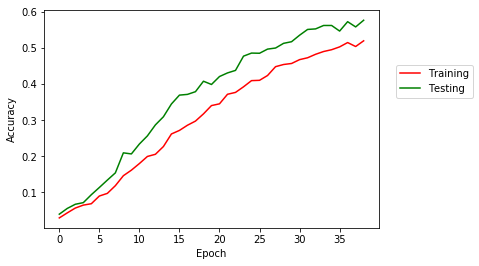

In [9]:
plt.plot(resultData['epoch'], resultData['acc'], color = 'red', label = "Training")
plt.plot(resultData['epoch'], resultData['val_acc'], color = 'green', label = "Testing")
plt.xticks(np.arange(0, 40, step=5))
plt.legend(bbox_to_anchor=(1.05, .75), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

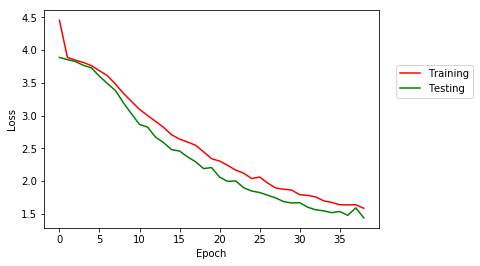

In [10]:
plt.plot(resultData['epoch'], resultData['loss'], color = 'red', label = "Training")
plt.plot(resultData['epoch'], resultData['val_loss'], color = 'green', label = "Testing")
plt.xticks(np.arange(0, 40, step=5))
plt.legend(bbox_to_anchor=(1.05, .75), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()